# Generating sequences by kinetic Monte-Carlo

Imports

In [1]:
import importlib
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error

import numpy as np

from Modules import utils, plot_utils

2022-12-08 15:28:41.515548: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Functions from MyModuleLibrary

In [3]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

def mae_cor(y_true, y_pred):
    """
	   Calculate the mean absolute error minus the correlation between
        predictions and  labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = mae_cor)
		>>> load_model('file', custom_objects = {'mae_cor : mae_cor})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))
    
    return 1 + mae - cor

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

#### Load models

In [4]:
data = 'SCerevisiae'
model_nucleosome = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
model_nucleosome2 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep2.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
model_nucleosome3 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep3.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# model_cohesine = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1_cohesine_3.hdf5', custom_objects={'correlate': correlate})
# model_pol2 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_pol2_2048_16_3.hdf5', custom_objects={'correlate' : correlate})

2022-12-08 15:28:50.683866: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-12-08 15:28:50.740609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:28:50.740784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-12-08 15:28:50.740837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:28:50.740952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

Random sequence generator

In [5]:
n = 10
seq_2001 = np.random.choice(['A', 'C', 'G', 'T'], (n, 2001))
one_hot_2001 = utils.one_hot_encoding(seq_2001, read_length=seq_2001.shape[1]).reshape(n, 2001, 1, 4)
seq_32768 = np.random.choice(['A', 'C', 'G', 'T'], (n, 32768))
one_hot_32768 = utils.one_hot_encoding(seq_32768, read_length=seq_32768.shape[1])
seq_2048 = np.random.choice(['A', 'C', 'G', 'T'], (n, 2048))
one_hot_2048 = utils.one_hot_encoding(seq_2048, read_length=seq_2048.shape[1])

Load chromosome

In [11]:
chr_id = 'chrXVI'
with np.load(Path(data_dir, data, 'genome', 'sacCer3.npz')) as f:
    one_hot_chr = f[chr_id]
one_hot_chr.shape

(948066, 4)

In [12]:
WINDOW = 2001
X = rolling_window(one_hot_chr, window=(WINDOW, 4))[:, 0, :, None, :]
X.shape

(946066, 2001, 1, 4)

Predict

In [15]:
pred = np.zeros(len(one_hot_chr))
pred[WINDOW//2:-(WINDOW//2)] = model_nucleosome.predict(X)[:, 0]
pred2 = np.zeros(len(one_hot_chr))
pred2[WINDOW//2:-(WINDOW//2)] = model_nucleosome2.predict(X)[:, 0]
pred3 = np.zeros(len(one_hot_chr))
pred3[WINDOW//2:-(WINDOW//2)] = model_nucleosome3.predict(X)[:, 0]

2022-12-08 15:41:05.032350: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 7572312264 exceeds 10% of free system memory.


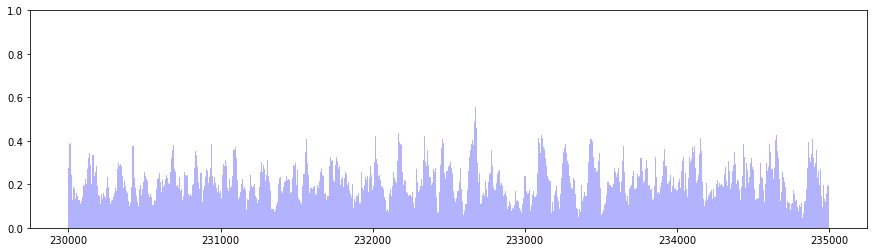

In [30]:
start = 230_000
end = 235_000
plt.figure(figsize=(15, 4))
plt.bar(np.arange(start, end), height=pred[start:end], width=1, alpha=0.3, color=(0, 0, 1))
# plt.bar(np.arange(start, end), height=pred2[start:end], width=1, alpha=0.3, color=(0, 1, 0))
# plt.bar(np.arange(start, end), height=pred3[start:end], width=1, alpha=0.3, color=(1, 0, 0))
plt.ylim(0, 1)
plt.show()
plt.close()

## Kinetic Monte Carlo

In [ ]:
# initialisation :
# use ATGC content from SCerevisiae
# build 1000 sequences of length N
# mutation and selection: 
# make every 3*N single nucleotide mutation
# selection probability of 1/norm * exp(-delta_energy / T)
# 10**4 steps
# save each configuration and keep best
# energy :
# create a 2001 + N sequence repeating the length N sequence, centered on it
# distance to target density E_reg is d(x, y) = 1 - corr(x, y) + 1/N * sum(abs(x_i - y_i))
# GC content constraint E_GC is abs(GC_synt - GC_nat) GC_nat=0.38
# E_mut penalizes sequences already seen
# E_rev, like E_reg but on reverse strand
# total energy is exp(-(a*E_GC + b*E_reg + c*E_rev + d*E_mut)/T)

In [21]:
SCer_GC = 0.38
SCer_p = [0.31, 0.19, 0.19, 0.31]

In [27]:
n_seqs = 2
seq_length = 3
seqs = np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, seq_length), p=SCer_p)
one_hots = utils.one_hot_encoding(seqs, read_length=seq_length, one_hot_type=int).reshape(n_seqs, seq_length, 1, 4)
one_hots

array([[[[0, 0, 0, 1]],

        [[0, 0, 0, 1]],

        [[0, 1, 0, 0]]],


       [[[1, 0, 0, 0]],

        [[0, 0, 0, 1]],

        [[0, 1, 0, 0]]]])

In [28]:
one_hots.shape

(2, 3, 1, 4)

In [29]:
mult = np.ones([1, 1]).reshape(1, 1, 1, 1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)